# Lab Four: The Multi-Layer Perceptron
 

#### Everett Cienkus, Blake Miller, Colin Weil

### 1. Load, Split, and Balance

#### 1.1 Load Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load the data into memory and save it to a pandas data frame.
df = pd.read_csv('census_dataset/acs2017_census_tract_data.csv')

# Remove any observations that having missing data.
df = df.dropna()

# Encode any string data as integers for now. 
le = LabelEncoder()
df['State'] = le.fit_transform(df['State'])
df['County'] = le.fit_transform(df['County'])

We are going to keep the county variable because this has many effects on if a child is in poverty or not. For example, somewhere like in Illinois, there can be a county that is one of the most rich counties in the country, a county that contains the inner city of Chicago, and a town in the Southwest of the state that is mostly farms. These three places are all very different and the county is a very good way to differentiate them.

#### 1.2 Split Dataset and Balance

In [2]:
# Divide your data into training and testing data using an 80% training 
# and 20% testing split. Use the cross validation modules that are part 
# of scikit-learn.
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, train_size=0.8)

# Uses quantization thresholds for the "ChildPoverty" 
# variable that equally divide the data into four classes
q1, q2, q3 = df_train['ChildPoverty'].quantile([0.25,0.5,0.75])
print(q1,q2,q3)
df_train['quantized_childPoverty'] = pd.cut(x=df_train['ChildPoverty'], bins=[-1,q1,q2,q3,101], labels=[1,2,3,4])
X_train = df_train.drop(columns = ['ChildPoverty','quantized_childPoverty']).to_numpy()
y_train = df_train['quantized_childPoverty'].to_numpy()

df_test['quantized_childPoverty'] = pd.cut(x=df_test['ChildPoverty'], bins=[-1,q1,q2,q3,101], labels=[1,2,3,4])
X_test = df_test.drop(columns = ['ChildPoverty','quantized_childPoverty']).to_numpy()
y_test = df_test['quantized_childPoverty'].to_numpy()

unique_ytrain, counts_ytrain = np.unique(y_train, return_counts=True)
print(np.asarray((unique_ytrain, counts_ytrain)).T)

6.2 16.3 31.6
[[    1 14637]
 [    2 14459]
 [    3 14573]
 [    4 14505]]


We balance the training and not the testing set because it is good to balance for training because then we have information for all of our classes but when we are testing, we want to test on the distributuion that would actually be the case in order to get an accurate represenation of the results for testing.

### 2. Pre-proccesing

In [3]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_) # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))
        
        W2_num_elems = (self.n_hidden)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden)
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [4]:
from sklearn.metrics import accuracy_score
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.b1,
                                                       self.b2
                                                      )
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                rho_W1, rho_W2 = eta * gradW1, eta * gradW2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2
                

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self
    

In [5]:
# to implement the new style of objective function, 
# we just need to update the final layer calculation of the gradient
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2

In [6]:
class TLPBetterInitial(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2

In [7]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

#### 2.1 Two-Layer Perceptron Network

Epoch: 40/40

CPU times: user 18.5 s, sys: 4.8 s, total: 23.3 s
Wall time: 5.05 s
No Normalization/ One Hot :
Resubstitution acc: 0.25050709939148075
Validation acc: 0.2458058305830583


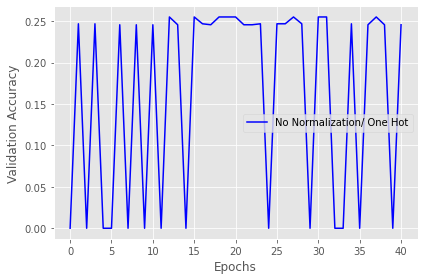

In [13]:
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':40, 'eta':0.01, # poor starting learning rate!!
         'alpha':0.001, 'decrease_const':0.1, 'decrease_iter':15,
         'minibatches':50,
         'shuffle':True,'random_state':1}

tlpPlain = TLPBetterInitial(**vals)
%time tlpPlain.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))

# print_result(tlpPlain,X_train,y_train,X_test,y_test,title="No Normalization/ One Hot",color="blue")
# plt.show()

#### 2.2 TLPNetwork with Normalizing the Continuous Numeric Feature Data

In [9]:
from sklearn.preprocessing import normalize

X_train_normalized = np.concatenate(( X_train[:,0:3], normalize(X_train[:,3:len(X_train[0])])), axis=1)
X_test_normalized = np.concatenate(( X_test[:,0:3], normalize(X_test[:,3:len(X_test[0])])), axis=1)

tlpNormal = TLPBetterInitial(**vals)
%time tlpNormal.fit(X_train_normalized, y_train, print_progress=1, XY_test=(X_test_normalized, y_test))

# print_result(tlpNormal,X_train,y_train,X_test,y_test,title="Normalization",color="green")
# plt.show()

Epoch: 40/40

CPU times: user 20.3 s, sys: 4.81 s, total: 25.1 s
Wall time: 5.62 s


#### 2.3 TLPNetwork with Normalizing + One Hot Encode the Categorical Data

In [10]:
# One Hot Encode the Categorical Data

# perform one-hot encoding of the categorical data "embarked"
# tmp_df = pd.get_dummies(df_imputed.Embarked,prefix='Embarked')
# df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe

# tmp_df = pd.get_dummies(df_imputed.Sex,prefix='Sex')
# df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe


tlpNormHot = TLPBetterInitial(**vals)
%time tlpNormHot.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))

# print_result(tlpNormHot,X_train,y_train,X_test,y_test,title="Normalization + One Hot",color="red")
# plt.show()

Epoch: 40/40

CPU times: user 18.8 s, sys: 4.78 s, total: 23.6 s
Wall time: 5.14 s


#### 2.4 Comparing the Performance of the Three Models

No Normalization/ One Hot :
Resubstitution acc: 0.25050709939148075
Validation acc: 0.2458058305830583
Normalization :
Resubstitution acc: 0.25050709939148075
Validation acc: 0.2458058305830583
Normalization + One Hot :
Resubstitution acc: 0.25050709939148075
Validation acc: 0.2458058305830583


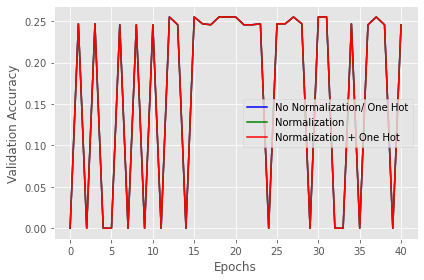

In [11]:
print_result(tlpPlain,X_train,y_train,X_test,y_test,title="No Normalization/ One Hot",color="blue")
print_result(tlpNormal,X_train,y_train,X_test,y_test,title="Normalization",color="green")
print_result(tlpNormHot,X_train,y_train,X_test,y_test,title="Normalization + One Hot",color="red")
plt.show()

Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have)

### 3. Modeling

Feed forward/ back propogation in for-loop for adding layers

MEGNEMAR for comparing

### 4. Adaptive momentum (AdaM) 